# MonReader

## CONTEXT

The client, focused in AI and Computer Vision has developed a mobile app "MonReader" that provides a document digitalization experience for the blind, for researchers, and for general users who want an automated solution for bulk-scanning documents.  

MonReader detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

## DATA DESCRIPTION

The Client collected page flipping video from smart phones and labelled them as "flipping" and "not flipping".

The client then clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber.

## PROJECT GOALS
- Predict if the page is being flipped using a single image.
- Predict if a given sequence of images contains an action of flipping.

### SUCCESS METRIC 
 - Evaluate model performance based on F1 score -> the greater it is, the better the model.

## METHODOLOGY

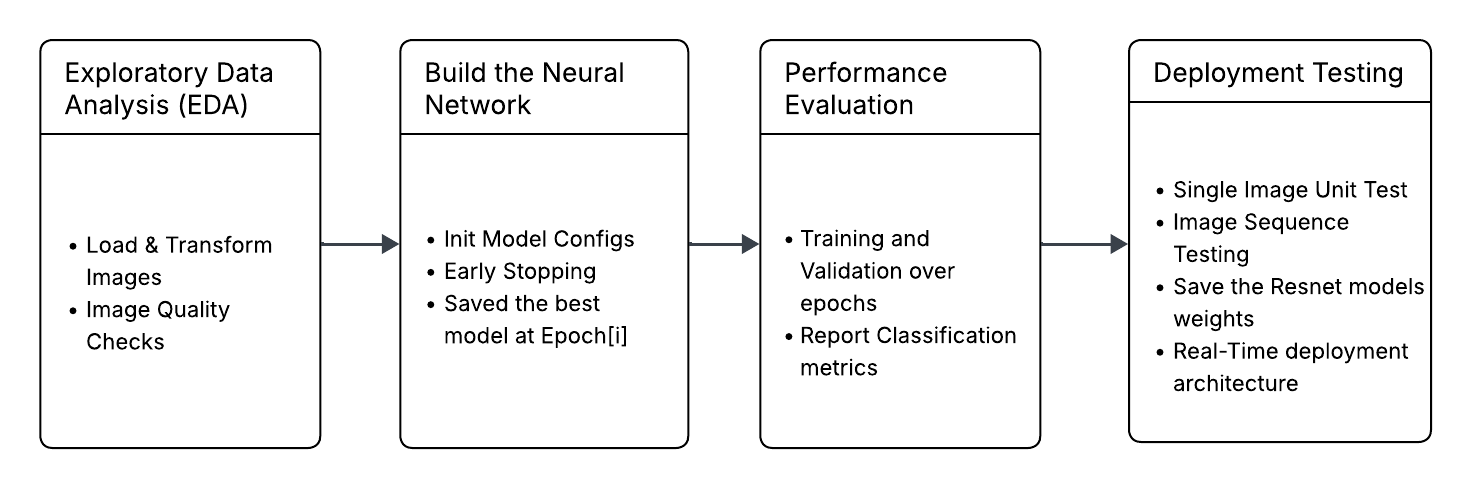

In [1]:
# import image reader libraries 
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image

# import data analysis libraries  
import numpy as np
import pandas as pd
import math
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

print("installed all dependencies...")

installed all dependencies...


## EXPLORATORY DATA ANALYSIS

### LOAD AND TRANSFORM IMAGES

In [2]:
# Define the directories
train_dir = 'images/training'
test_dir = 'images/testing'

# Apply basic transfromations to images in the training and test datsets

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to fixed size
    transforms.RandomHorizontalFlip(),    # Augmentation
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize([0.5], [0.5])    # Normalize (can adjust later)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load full training set
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Split the training data into -> 80% train and 20% validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define the test set - the unseen dataset to be later tested upon
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Load images into train, validation and test using the DataLoader object
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Test the class names which are the sub-directories -> should be "flip" and "notflip"
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['flip', 'notflip']


#### OBSERVATIONS
- The classes in the dataset are detected to be "flip" and "notflip" -> the subfolders itself as expected. 

### IMAGE QUALITY CHECKS

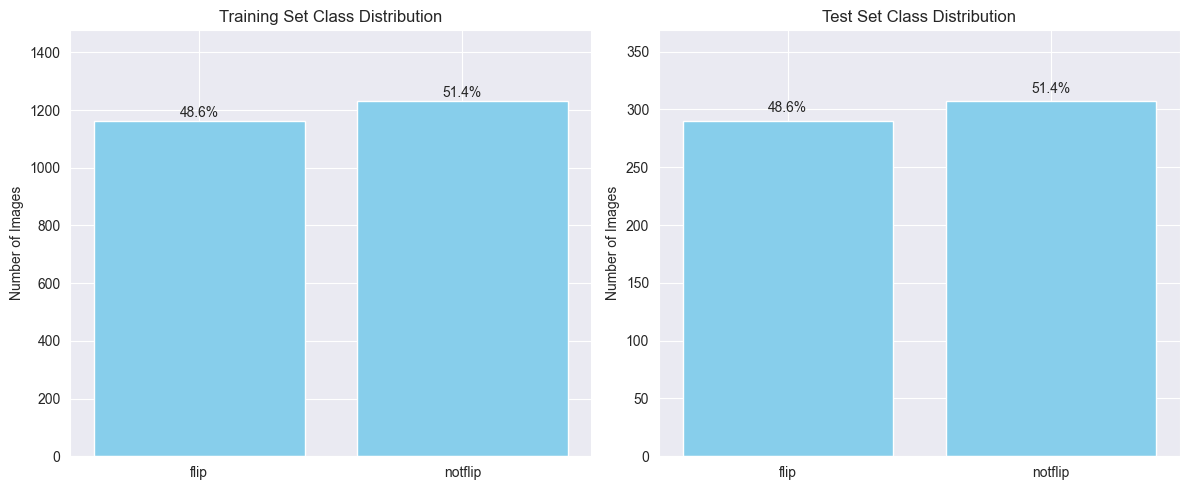

In [3]:
'''
count_images_per_class() : function to count the numbers in flip and notflip classes 
@param : data_dir - the directory/folder of the images for the particular class
@return : class_count - dict containing of frequency of images of a class as <Key, Value> : <Class, Image Frequency>
'''
def count_images_per_class(data_dir):
    class_counts = {} # init dict
    for class_name in os.listdir(data_dir): # iterate within the folder
        class_path = os.path.join(data_dir, class_name) # set the fullpath to class/subfolder
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path)) # get the length of subfolder i.e. no of files/images
    return class_counts

# Get counts for train and test 
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

'''
plot_class_distributions() : function to generate a count of no. of images in each class in training and test datasets
@param : train_counts - dictionary holding the no. of images in training dataset, test_counts - the same for the test dataset
@return : None
'''
def plot_class_distributions(train_counts, test_counts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, counts, title in zip(axes, [train_counts, test_counts], ['Training Set', 'Test Set']):
        total = sum(counts.values())
        classes = list(counts.keys())
        values = list(counts.values())
        percentages = [f"{(v / total) * 100:.1f}%" for v in values]

        bars = ax.bar(classes, values, color='skyblue')
        ax.set_title(f"{title} Class Distribution")
        ax.set_ylabel("Number of Images")
        ax.set_ylim(0, max(values) * 1.2)

        # Add percentage labels
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5, pct,
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Run the plot
plot_class_distributions(train_counts, test_counts)

#### OBSERVATIONS
- The training dataset has ~2400 images and test dataset ~600 images -> so, it has a nearly predefined 80-20 train-test split.
- The no. of flip and notlfip images in both the training and test datasets are nearly 50-50.
- So, the provided dataset in fairly balanced in terms of data collection and labeling. 

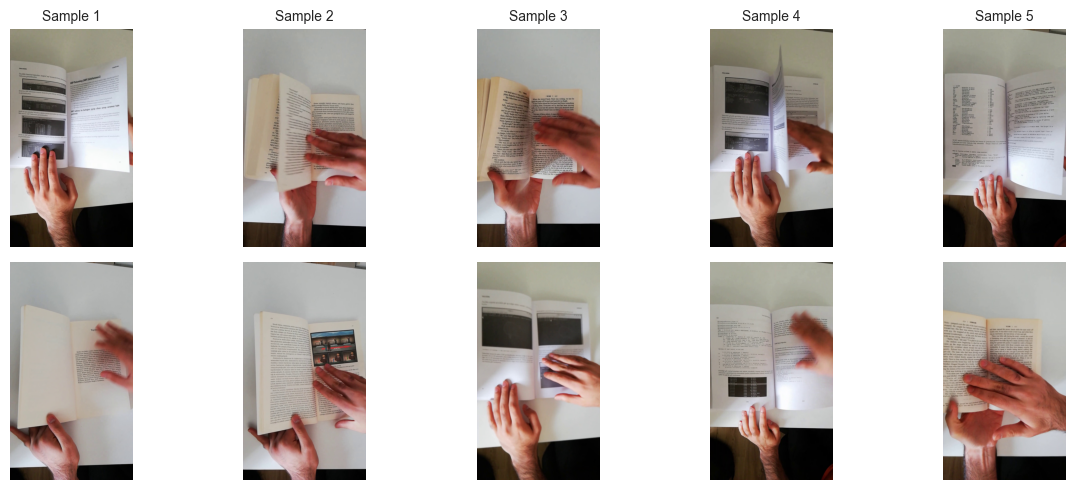

In [4]:
'''
display_samples_from_each_class() : function to display some image samples from each class 
@param : base_dir - the root directory, classes - array holding the class names, samples_per_class - no. of images to display set to 5 
@return : None
'''
def display_samples_from_each_class(base_dir, classes, samples_per_class=5):
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 2.5, len(classes) * 2.5))

    for row_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_dir, class_name)
        all_images = os.listdir(class_path)
        sample_images = random.sample(all_images, samples_per_class)

        for col_idx, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)

            ax = axes[row_idx, col_idx] if len(classes) > 1 else axes[col_idx]
            ax.imshow(image)
            ax.axis('off')

            if row_idx == 0:
                ax.set_title(f"Sample {col_idx+1}", fontsize=10)
            if col_idx == 0:
                ax.set_ylabel(class_name, fontsize=12)

    plt.tight_layout()
    plt.show()

# Use training directory

class_names = os.listdir(train_dir)
display_samples_from_each_class(train_dir, class_names, samples_per_class=5)

#### OBSERVATIONS
- From the image samples of the "flip" class, it can be noticed that the pages are being turned or folded - sign of a phyiscal "page flip".
- From the image samples of the "notflip" class, the pages do not fold or turn, hence no sign of a page flip.

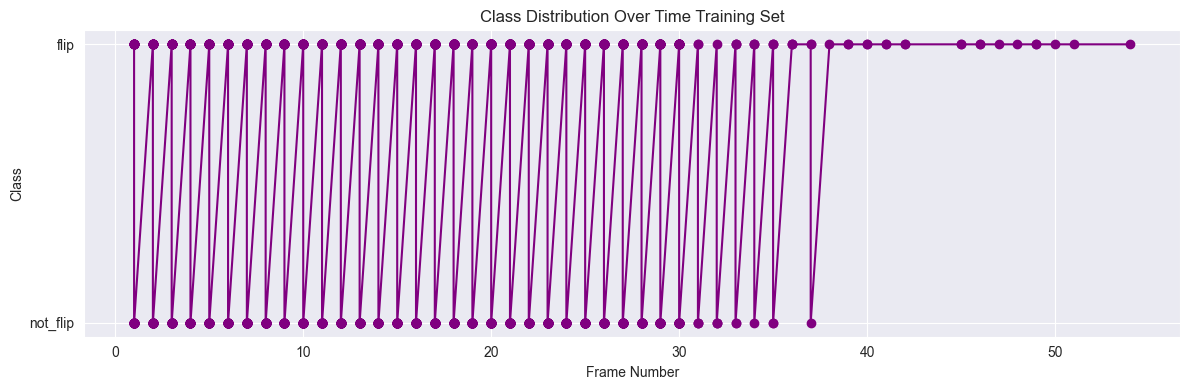

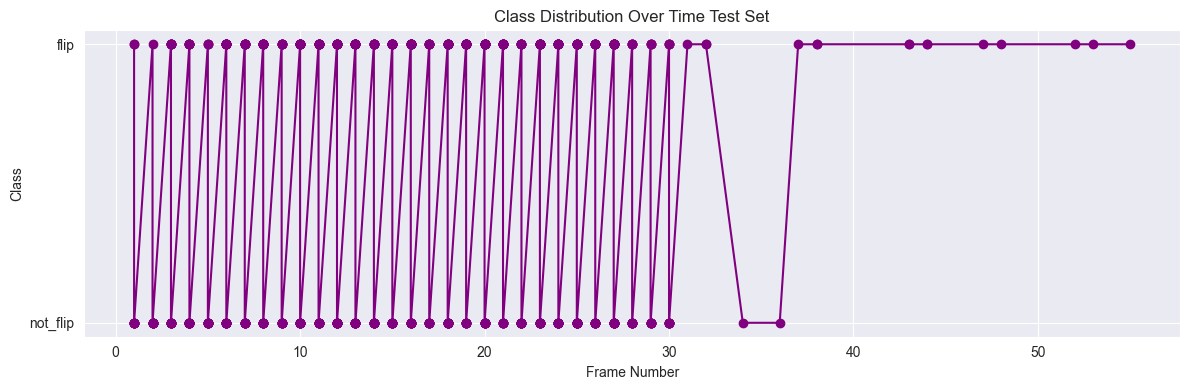

In [5]:
'''
class_timeline_from_filenames() : function to generate a line plot of the class distribution over time of image sequences in each class
@param : data_dir - the director of train/test classes, label - custom label for the plot  
@return : None
'''

def class_timeline_from_filenames(data_dir, label=''):
    entries = []
    for label_name in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                parts = filename.replace('.jpg', '').replace('.png', '').split('_')
                if len(parts) == 2:
                    frame_num = int(parts[1])
                    entries.append((frame_num, label_name))

    # Sort by frame index
    entries.sort()
    frame_nums = [e[0] for e in entries]
    labels = [1 if e[1] == 'flip' else 0 for e in entries]  # flip=1, not_flip=0

    plt.figure(figsize=(12, 4))
    plt.plot(frame_nums, labels, marker='o', linestyle='-', color='purple')
    plt.yticks([0, 1], ['not_flip', 'flip'])
    plt.xlabel("Frame Number")
    plt.ylabel("Class")
    plt.title(f"Class Distribution Over Time {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# call the functions 
class_timeline_from_filenames(train_dir, label='Training Set')
class_timeline_from_filenames(test_dir, label = 'Test Set')

#### OBSERVATIONS
- In the training dataset, alternating images are flip and notflip until about image #35 - from there on flip label is constant.
- In the test set, the pattern is mostly identical which some minor fluctuations around #34 and #35 - constant flip label from there on as well.
- Overall, the sequential behavior is consistent between both training and test datasets.  

## BUILD THE NEURAL NETWORK (CNN)

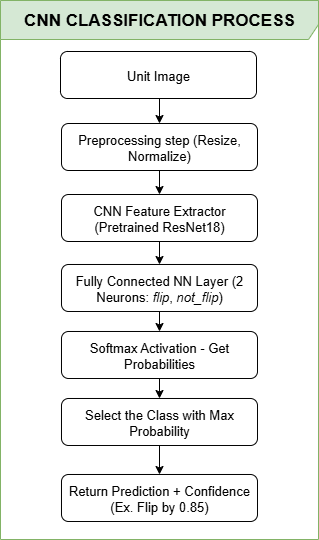

In [6]:
# import pytorch dependencies used for CNN 
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from sklearn.metrics import f1_score
from tqdm import tqdm

'''
1. INIT MODEL CONFIGS
'''
# Setup the virtual device config for the CNN to run on 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a resnet CNN model 
model = models.resnet18(pretrained=True)

# Set the default params for the resnet for the current iteration
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features, 2) # ensure the model features remain consistent w.r.t preceding layer 
model = model.to(device) # store the model in the define device 

criterion = nn.CrossEntropyLoss() # Set the loss function - used to measure the difference between actual v/s predicted labels
optimizer = Adam(model.fc.parameters(), lr=0.01) # Set the optimizer that iteratively updates the model params to minimize train/val losses

'''
2. IMPLEMENT EARLY STOPPING
'''
# Init early stopping params
patience = 3
best_f1 = 0
epochs_no_improve = 0
best_model_state = None

# Init array to track lossess and F-1 scores over epochs 
train_losses, train_f1s = [], []
val_losses, val_f1s = [], []

num_epochs = 15  # upper limit

# iterate over each epoch
for epoch in range(num_epochs):
    model.train() # train model during each epoch 
    running_loss = 0.0
    all_preds, all_labels = [], []

    # perform the prediction, get the labels and apply the loss function and optimizer - training set
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # compute the training loss and F-1 score at that epoch
    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

    # Now evaluate the model on the validation set in this epoch 
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    # perform the prediction, get the labels and apply the loss function and optimizer - validation set
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # compute the validation loss and F-1 score at that epoch
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1} — Train Loss: {train_loss:.4f} — Train F1: {train_f1:.4f} — Val Loss: {val_loss:.4f} — Val F1: {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val F1: {best_f1:.4f}")
            break
'''
3. LOAD THE BEST MODEL WEIGHTS AT EPOCH[i]
'''
# Load best model weights
if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.48s/it]


Epoch 1 — Train Loss: 0.9959 — Train F1: 0.6269 — Val Loss: 0.4827 — Val F1: 0.7171


Epoch 2/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.18s/it]


Epoch 2 — Train Loss: 0.3748 — Train F1: 0.8251 — Val Loss: 0.3397 — Val F1: 0.8389


Epoch 3/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.44s/it]


Epoch 3 — Train Loss: 0.2687 — Train F1: 0.8966 — Val Loss: 0.2475 — Val F1: 0.9123


Epoch 4/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.26s/it]


Epoch 4 — Train Loss: 0.2541 — Train F1: 0.8946 — Val Loss: 0.2518 — Val F1: 0.8923


Epoch 5/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.43s/it]


Epoch 5 — Train Loss: 0.2003 — Train F1: 0.9371 — Val Loss: 0.2657 — Val F1: 0.8815


Epoch 6/15 - Validation: 100%|███████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.41s/it]

Epoch 6 — Train Loss: 0.1993 — Train F1: 0.9302 — Val Loss: 0.3117 — Val F1: 0.8589
Early stopping at epoch 6. Best Val F1: 0.9123


## PERFORMANCE EVALUATION

### TRAINING AND VALIDATION OVER EPOCHS

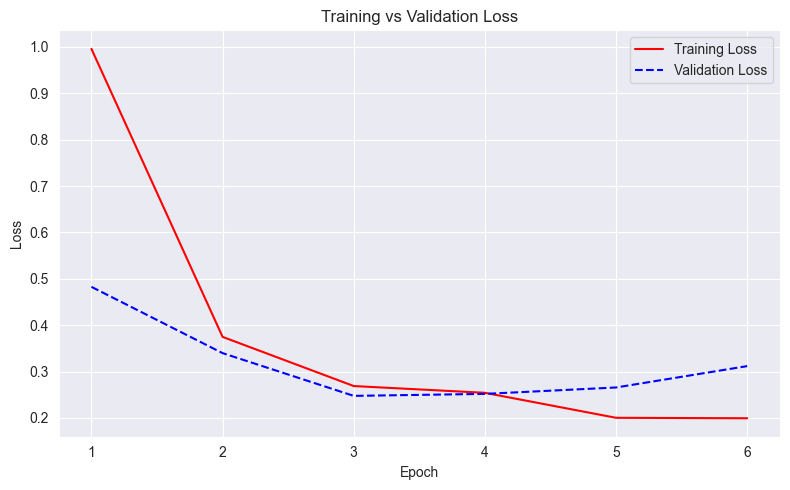

In [7]:
'''
plot_loss_curves() : function to generate a line plot of the training v/s validation over the no. of epochs at early stopping
@param : train_losses - array holding the traning loss at each epoch, val_losses - array holding the validation loss at each epoch 
@return : None
'''

def plot_loss_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'r-', label='Training Loss')
    plt.plot(epochs, val_losses, 'b--', label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# call the function
plot_loss_curves(train_losses, val_losses)

### CLASSFICATION METRICS REPORTING


 Classification Report for Training Set:
              precision    recall  f1-score   support

        flip       0.78      1.00      0.87       918
     notflip       0.99      0.74      0.85       995

    accuracy                           0.86      1913
   macro avg       0.89      0.87      0.86      1913
weighted avg       0.89      0.86      0.86      1913

 F1 Score (Training): 0.8619


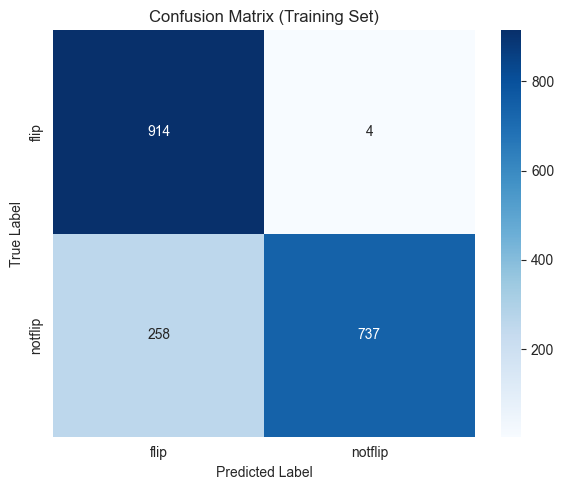


 Classification Report for Validation Set:
              precision    recall  f1-score   support

        flip       0.77      1.00      0.87       244
     notflip       0.99      0.69      0.82       235

    accuracy                           0.85       479
   macro avg       0.88      0.84      0.84       479
weighted avg       0.88      0.85      0.84       479

 F1 Score (Validation): 0.8432


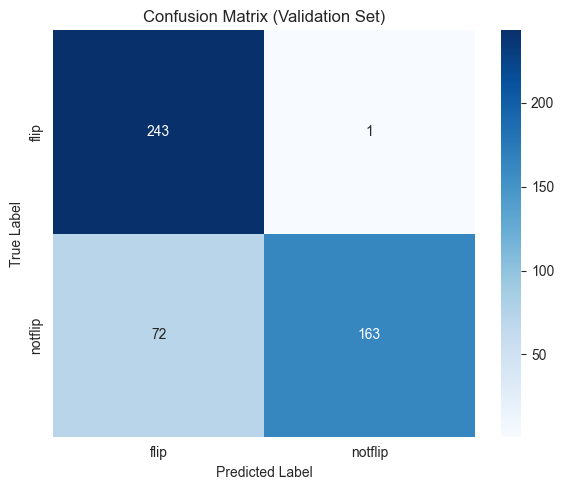


 Classification Report for Test Set:
              precision    recall  f1-score   support

        flip       0.76      0.99      0.86       290
     notflip       0.98      0.70      0.82       307

    accuracy                           0.84       597
   macro avg       0.87      0.84      0.84       597
weighted avg       0.87      0.84      0.84       597

 F1 Score (Test): 0.8369


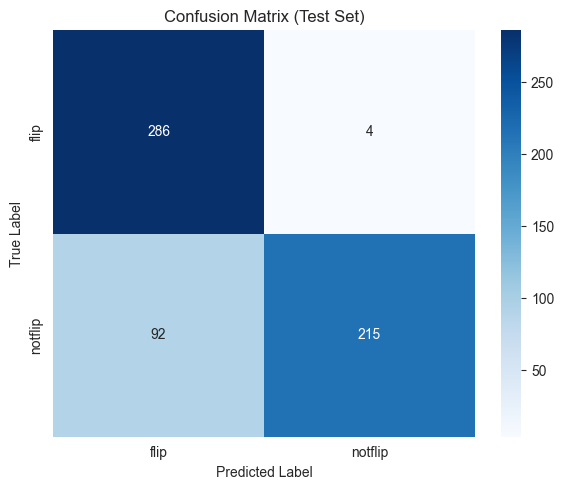

Classification Report For Training Set
              precision    recall  f1-score   support

        flip       0.78      1.00      0.87       918
     notflip       0.99      0.74      0.85       995

    accuracy                           0.86      1913
   macro avg       0.89      0.87      0.86      1913
weighted avg       0.89      0.86      0.86      1913

Classification Report For Validation Set
              precision    recall  f1-score   support

        flip       0.77      1.00      0.87       244
     notflip       0.99      0.69      0.82       235

    accuracy                           0.85       479
   macro avg       0.88      0.84      0.84       479
weighted avg       0.88      0.85      0.84       479

Classification Report For Test Set
              precision    recall  f1-score   support

        flip       0.76      0.99      0.86       290
     notflip       0.98      0.70      0.82       307

    accuracy                           0.84       597
   macro avg 

In [8]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

'''
plot_confusion_matrix() : function to generate the confusion matrix and a heatmap based on the classification report
@param : y_true - the actual values of flip/notflip for each image, y_pred - the corresponding predicted value from the resnet model
@return : None
'''

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

'''
evaluate_model() : function to generate and print the classification report for traning, validation and test data
@param : dataloader - the dataloader object defined in the EDA, class_names: array holding the classes "flip" and "notflip"
@return : predictions values, prediction labels, confidence scores 
'''


def evaluate_model(model, dataloader, class_names, dataset_name=""):
    
    model.eval() # compile the model 
    # init arrays to store outputs 
    all_preds = []
    all_labels = []
    confidence_scores = []  

    # run the model 
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)  
            conf, preds = torch.max(probs, 1)      

            # append the computations to the arrays 
            confidence_scores.extend(conf.cpu().numpy())  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n Classification Report for {dataset_name} Set:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print(f" F1 Score ({dataset_name}): {f1_score(all_labels, all_preds, average='macro'):.4f}")

    plot_confusion_matrix(all_labels, all_preds, class_names, title=f"Confusion Matrix ({dataset_name} Set)")

    return all_preds, all_labels, confidence_scores  


# call the functions on each set - training, validation and lastly on the test/unseen data 

train_preds, train_labels, train_confidences = evaluate_model(model, train_loader, class_names, dataset_name="Training")
val_preds, val_labels, val_confidences = evaluate_model(model, val_loader, class_names, dataset_name="Validation")
test_preds, test_labels, test_confidences = evaluate_model(model, test_loader, class_names, dataset_name="Test")

# Training Set
print("Classification Report For Training Set")
print(classification_report(train_labels, train_preds, target_names=class_names))

# Validation Set
print("Classification Report For Validation Set")
print(classification_report(val_labels, val_preds, target_names=class_names))

# Test Set
print("Classification Report For Test Set")
print(classification_report(test_labels, test_preds, target_names=class_names))



#### OBSERVATIONS
- The pretrained ResNet18 model returns a very good F-1 score on the unseen data of 0.86 in predicting a flip. 
- This indicates that the current model itself achieves the desired objective as well as maintains a balance b/w precision and recall (for flip class).
- Hence, we need not further tune the current model as it could either over-engineering the model or would not yield any significant difference.


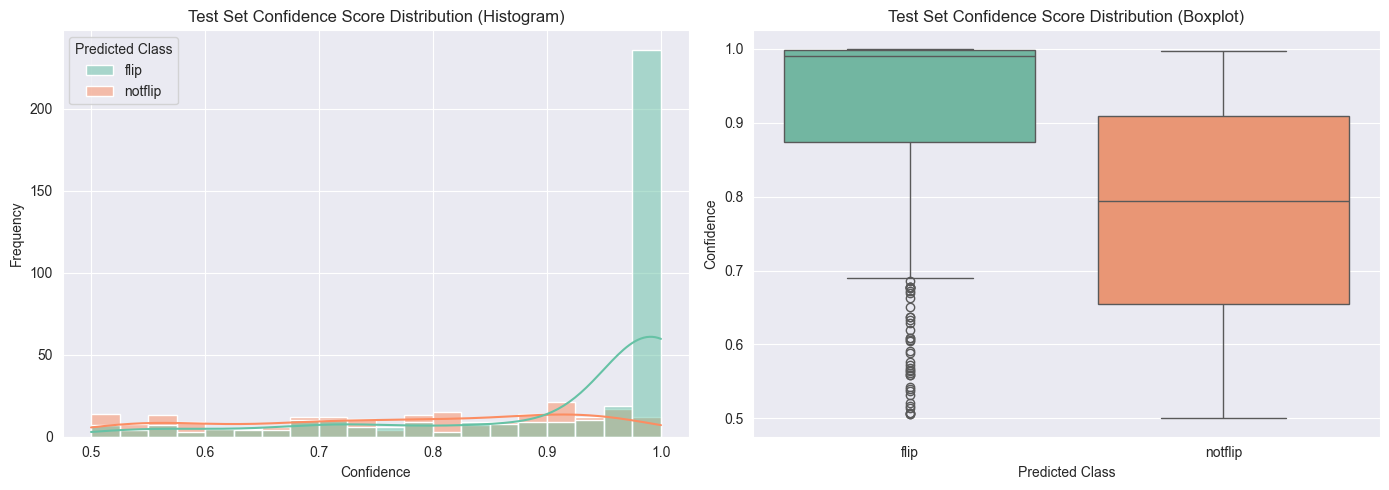

In [9]:
# store the confidence probabilities in a pandas dataframe for visualization purposes
df_conf_test = pd.DataFrame({
    "Confidence": test_confidences,
    "Predicted Class": [class_names[i] for i in test_preds]
})


# init a fig 
plt.figure(figsize=(14, 5))

# Histogram of confidence scores
plt.subplot(1, 2, 1)
sns.histplot(data=df_conf_test, x="Confidence", hue="Predicted Class", bins=20, kde=True, palette="Set2")
plt.title("Test Set Confidence Score Distribution (Histogram)")
plt.xlabel("Confidence")
plt.ylabel("Frequency")

# Boxplot of confidence scores per predicted class
plt.subplot(1, 2, 2)
sns.boxplot(data=df_conf_test, x="Predicted Class", y="Confidence", palette="Set2")
plt.title("Test Set Confidence Score Distribution (Boxplot)")
plt.ylabel("Confidence")

plt.tight_layout()
plt.show()

#### OBSERVATIONS

- The histogram shows a strong peak above the 0.8 mark, indicating that the model is highly confident in the majority of its predictions.
- The boxplot reveals that both flip and notflip classes have a narrow interquartile range (IQR), with median confidence scores close to 1.0 -implying a reliable performance across both classes.
- Although few samples fall below the 0.6–0.7 range, visible in the left tail of the histogram and as outliers in the boxplot. These may be borderline or ambiguous images worth reviewing for improvement.

## DEPLOYMENT TESTING

### SINGLE IMAGE UNIT TEST

In [10]:
from IPython.display import display
import ipywidgets as widgets

# define a basic image loader widget
uploader = widgets.FileUpload(accept='.jpg,.png', multiple=False)
display(uploader)

FileUpload(value=(), accept='.jpg,.png', description='Upload')

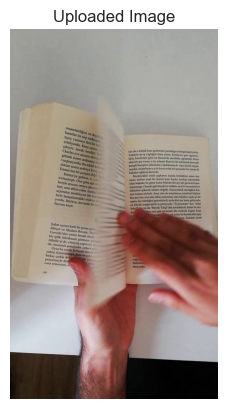

 Prediction: **flip** (Confidence: 98.26%)


In [11]:
from io import BytesIO
from PIL import Image
import torchvision.transforms as transforms
import torch

# Ensure model is in eval mode - as it was in validation set during model compilation 
model.eval()

# fetch it from the EDA
class_names = full_train_dataset.classes

'''
predict_image_from_uploader() : function to predict where the uploaded image is "flip" or "notflip" and its prediction confidence (probability)  
@param : None
@return : None
'''
def predict_image_from_uploader():
    if not uploader.value:
        print("Please upload an image first.")
        return

    # Support both dictionary and tuple-based formats
    upload_content = next(iter(uploader.value.values())) if isinstance(uploader.value, dict) else uploader.value[0]

    # Open image
    image = Image.open(BytesIO(upload_content['content'])).convert('RGB')

    # Show image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)

    predicted_class = class_names[pred.item()]
    confidence = conf.item() * 100

    print(f" Prediction: **{predicted_class}** (Confidence: {confidence:.2f}%)")

# Then just run:
predict_image_from_uploader()


#### OBSERVATIONS
- The uploaded sample image was the from the flip class of the unseen test data.
- The ResNet18 model correctly predicted it as a "Flip" with a confidence of ~89% i.e. the model is 89% certain that this image was a flip. 

### IMAGE SEQUENCE TESTING

In [12]:
from IPython.display import display
import ipywidgets as widgets

# update the image loader widget to take in multiple images as sequence 
uploader = widgets.FileUpload(accept='.jpg,.png', multiple=True)
display(uploader)

FileUpload(value=(), accept='.jpg,.png', description='Upload', multiple=True)

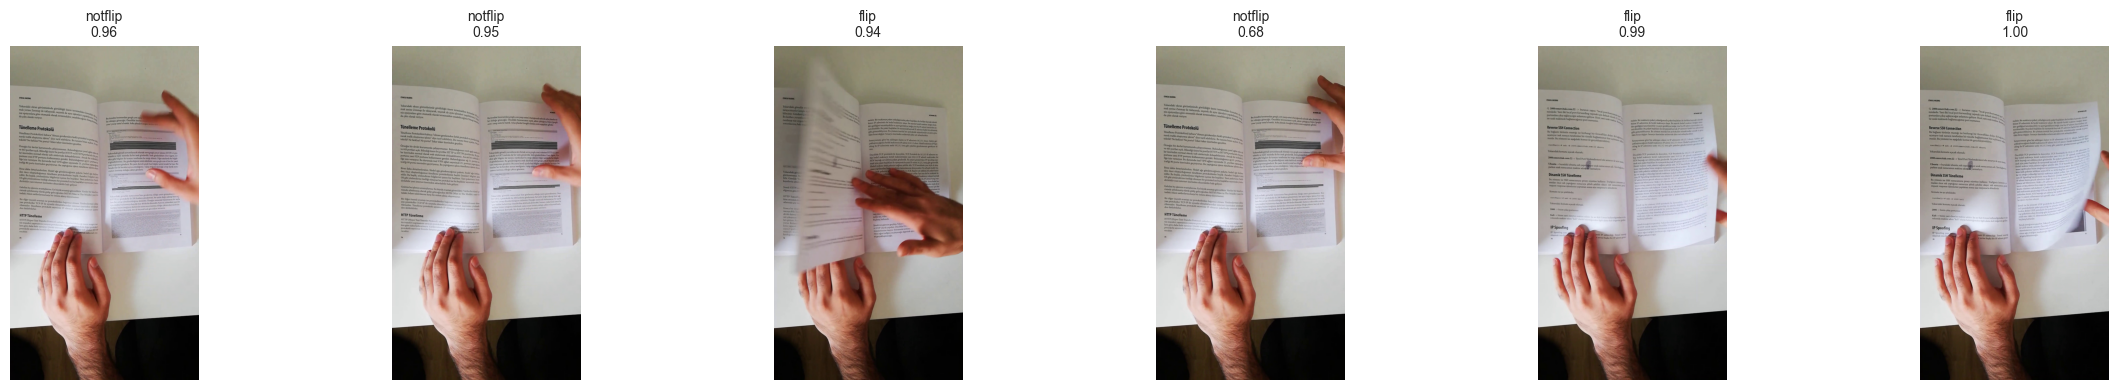

 Sequence classified as: **flip**
  Flip detected with confidence ≥ 80%: True


In [13]:
# Ensure model is in eval mode
model.eval()

# fetch it from the EDA
class_names = full_train_dataset.classes  # ['flip', 'not_flip']

# Transform (reuse for all images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

'''
predict_image_sequence() : function to predict whether the uploaded image sequence contains a flipping action
                           A flipping action is defined as - atleast 1 image in sequence must be a "flip" with atleast 80% confidence 
@param : None
@return : None
'''
def predict_image_sequence(conf_threshold=0.80):
    if not uploader.value:
        print("Please upload image(s) first.")
        return

    uploaded_files = uploader.value.values() if isinstance(uploader.value, dict) else uploader.value
    all_images = []
    pred_labels = []
    pred_confidences = []

    flip_detected = False

    for file in uploaded_files:
        image = Image.open(BytesIO(file['content'])).convert('RGB')
        all_images.append(image)

        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            conf, pred = torch.max(probs, 1)

        predicted_class = class_names[pred.item()]
        confidence = conf.item()

        pred_labels.append(predicted_class)
        pred_confidences.append(confidence)

        # Early stop if a high-confidence flip is found
        if predicted_class == 'flip' and confidence >= conf_threshold:
            flip_detected = True

    # Display
    fig, axes = plt.subplots(1, len(all_images), figsize=(4 * len(all_images), 4))
    if len(all_images) == 1:
        axes = [axes]

    for ax, img, label, conf in zip(axes, all_images, pred_labels, pred_confidences):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{label}\n{conf:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

    # Final decision
    if len(pred_labels) == 1:
        print(f" Prediction: **{pred_labels[0]}** (Confidence: {pred_confidences[0]*100:.2f}%)")
    else:
        print(f" Sequence classified as: **{'flip' if flip_detected else 'not_flip'}**")
        print(f"  Flip detected with confidence ≥ {conf_threshold*100:.0f}%: {flip_detected}")

predict_image_sequence()

#### OBSERVATIONS

- The uploaded sequence of images is a mix of "flip" and "not flip" from the unseen data.
- It uses a rules-based approach - if atleast one image in the sequence is a flip AND has atleast 80% confidence, then the entire sequence is flip.

### SAVE THE RESNET MODEL AND ITS WEIGHTS

In [14]:
# Save model weights
torch.save(model.state_dict(), "deployments/flip_classifier_weights_v3.pth")
print("Model weights saved as 'flip_classifier_weights_v3.pth'")

torch.save(model, "deployments/flip_classifier_model_v3.pth")
print("Entire model saved as 'flip_classifier_model_v3.pth'")

Model weights saved as 'flip_classifier_weights_v3.pth'
Entire model saved as 'flip_classifier_model_v3.pth'


### REAL-TIME DEPLOYMENT ARCHITECTURE

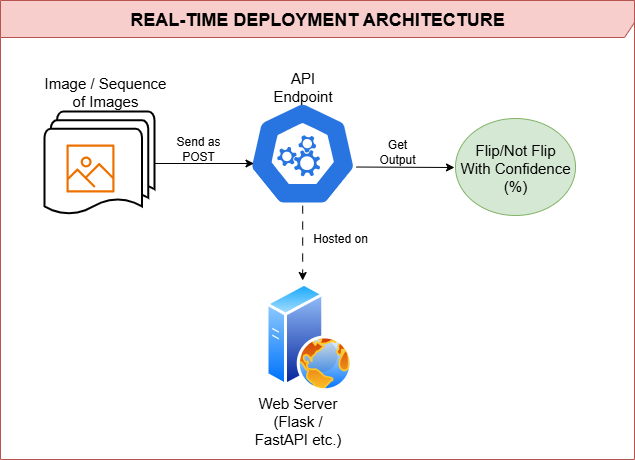